In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import KFold, train_test_split
import statistics

## Compute MSE Function

In [2]:
# define function to compute test MSEs
def comp_mse(model, temp_data):
    predictions = model.predict(temp_data)
    mse_test = np.mean((temp_data['Withdraw']-predictions)**2)    
    return mse_test

## Read the data

In [43]:
# Read the data
data=pd.read_csv('ATM_sample.csv')
data.head()

# Define target variable
y = data['Withdraw']

# Define the input variables
X = data.drop(columns=['Withdraw'])

X.columns

Index(['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High'], dtype='object')

## Alter the input columns (X) as you see fit

The following example adds combination variables split on downtown.

In [ ]:
X_temp = X.drop(columns=['Downtown']).mul(X['Downtown'], axis=0).rename(columns={'Shops': "Shops_DT", 'ATMs': "ATMs_DT", 'Weekday': "Weekday_DT", 'Center': 'Center_DT', 'High': "High_DT"})  

X_temp['Downtown_NotWeekday_Center'] = X['Downtown'] * (1 - X['Weekday'] ) * X['Center']
X_temp["Shops_DWC"] = X_temp['Downtown_NotWeekday_Center'] * X['Shops']
X_temp["ATMs_DWC"] = X_temp['Downtown_NotWeekday_Center'] * X['ATMs'] 

In [45]:
X_new = pd.concat([X_temp,X], axis=1)
X_new.head()

,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Downtown_NotWeekday_Center,Shops_DWC,ATMs_DWC,Shops,ATMs,Downtown,Weekday,Center,High
0,1018,10,0,0,0,0,0,0,1018,10,1,0,0,0
1,974,10,1,0,0,0,0,0,974,10,1,1,0,0
2,0,0,0,0,0,0,0,0,96,2,0,0,0,1
3,958,9,1,0,1,0,0,0,958,9,1,1,0,1
4,0,0,0,0,0,0,0,0,103,4,0,1,0,1


## Run model with ALL the added input variables

This is an optional step so we can see the base line model results. We can examine the p variables to determine which variables should be excluded.

In [33]:
# Preprocess the data 
X_train, X_test, y_train, y_test = train_test_split(
    X_new,              # Features
    y,                  # Target variable
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=2      # Set for reproducibility
)

train = pd.concat([y_train,X_train], axis=1)
test = pd.concat([y_test,X_test], axis=1)
 
train.head()


,Withdraw,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Downtown_NotWeekday_Center,Shops_DWC,ATMs_DWC,Shops,ATMs,Downtown,Weekday,Center,High
17341,14.965891,0,0,0,0,0,0,0,0,98,3,0,1,0,0
7611,74.790130,1028,9,0,0,0,0,0,0,1028,9,1,0,0,0
20724,17.032830,0,0,0,0,0,0,0,0,97,4,0,0,0,0
20722,76.284842,1009,8,1,1,1,0,0,0,1009,8,1,1,1,1
19744,16.760702,0,0,0,0,0,0,0,0,94,4,0,0,0,0


In [55]:
# Model
formula = f'Withdraw ~ {" + ".join(X_train.columns)}'  

model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
model.summary()

Test MSE:  0.26691716700246565
Train MSE:  0.2720670026794222


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.905e+06
Date:                Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:15:14   Log-Likelihood:                -13518.
No. Observations:               17600   AIC:                         2.707e+04
Df Residuals:                   17585   BIC:                         2.718e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     18.8371      0.145    130.328      0.000      18.554      19.120
Shops_DT                       0.0920      0.001     63.740      0.000       0.089       0.095
ATMs_DT                       -0.0112      0.007     -1.515      0.130      -0.026       0.003
Weekday__DT                    0.2338      0.019     12.200      0.000       0.196       0.271
Center_DT                     -0.5992      0.030    -20.023      0.000      -0.658      -0.541
High_DT                       -0.0272      0.019     -1.451      0.147      -0.064       0.010
Downtown_NotWeekday_Center    -1.3883      1.468     -0.946      0.344      -4.266       1.489
Shops_DWC                      0.0214      0.001     14.660      0.000       0.019       0.024
ATMs_DWC                      -0.0015      0.014     -0.109      0.913      -0.029       0.026
Shops                          0.0180      0.001     12.627      0.000       0.015       0.021
ATMs                          -0.9877      0.007   -141.212      0.000      -1.001      -0.974
Downtown                     -47.7776      0.278   -172.136      0.000     -48.322     -47.234
Weekday                       -2.2279      0.016   -141.798      0.000      -2.259      -2.197
Center                         3.6128      0.023    153.813      0.000       3.567       3.659
High                           1.0188      0.016     64.804      0.000       0.988       1.050
==============================================================================
Omnibus:                       55.087   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.040
Skew:                           0.107   Prob(JB):                     1.51e-13
Kurtosis:                       3.186   Cond. No.                     4.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Best Subset Selection

AIC, BIC, test MSE all used. An interesting feature might be to change the train test split.

In [8]:
# Initialize lists to store metrics
aic = []
bic = []
p = []
test_mse = []

# Start time measurement
start_time = time.time()

count = 1

# Null model with just the intercept
formula = 'Withdraw ~ 1'
model = ols(formula, data=train).fit()
aic.append(model.aic)
bic.append(model.bic)
test_mse.append(comp_mse(model, test))
p.append(1)

# Initialize best metrics with the null model
best_aic = model.aic
best_bic = model.bic
best_model_aic = formula
best_model_bic = formula
best_p_aic = 1
best_p_bic = 1
best_test_mse = test_mse[-1]
best_model_test_mse = formula

# Iterate over all combinations of predictors
for i in range(1, len(X_train.columns) + 1):

    # Reintialise best_train_mse for each i
    best_train_mse = np.inf 

    for combo in itertools.combinations(X_train.columns, i):
        # Create the model formula
        formula = f'Withdraw ~ {" + ".join(combo)}'
        model = ols(formula, data=train).fit()
        train_mse = comp_mse(model, train)

        # Store the AIC, BIC, and number of parameters using append
        aic.append(model.aic)
        bic.append(model.bic)
        p.append(i + 1)
        
        # Update best AIC model if current model is better
        if model.aic < best_aic:
            best_model_aic = formula
            best_aic = model.aic
            best_p_aic = i + 1 
        
        # Update best BIC model if current model is better
        if model.bic < best_bic:
            best_model_bic = formula
            best_bic = model.bic
            best_p_bic = i + 1 

        count += 1

        #use train MSE to select the best set for a given number of predictors i
        if train_mse < best_train_mse:
            best_model_train_mse = formula
            best_model_fit_train_mse = model
            best_train_mse = train_mse

    # once the best set was found for given i compute test mse
    test_mse.append(comp_mse(best_model_fit_train_mse, test))

    # Update best model based on test_mse if current model is better
    if test_mse[-1] < best_test_mse:
        best_model_test_mse = best_model_train_mse
        best_test_mse = test_mse[-1]
        best_p_test = i + 1

    end_time = time.time()
    elapsed_time = end_time - start_time

# Output the best model
print(f"Best subset selection took {count} iterations and {elapsed_time:.2f} seconds. Best model based on each statistic is as follows (includes intercept):")
print(f"AIC={best_aic:.2f} with {best_p_aic} parameters:\n {best_model_aic}\n")
print(f"BIC={best_bic:.2f} with {best_p_bic} parameters:\n {best_model_bic}\n") 
print(f"test MSE: {best_test_mse:.2f} has {best_p_test} parameters:\n {best_model_test_mse}")

Best subset selection took 16384 iterations and 547.72 seconds. Best model based on each statistic is as follows (includes intercept):
AIC=27063.54 with 13 parameters:
 Withdraw ~ Shops_DT + ATMs_DT + Weekday__DT + Center_DT + High_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High

BIC=27149.43 with 11 parameters:
 Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High

test MSE: 0.27 has 15 parameters:
 Withdraw ~ Shops_DT + ATMs_DT + Weekday__DT + Center_DT + High_DT + Downtown_NotWeekday_Center + Shops_DWC + ATMs_DWC + Shops + ATMs + Downtown + Weekday + Center + High


<Axes: >

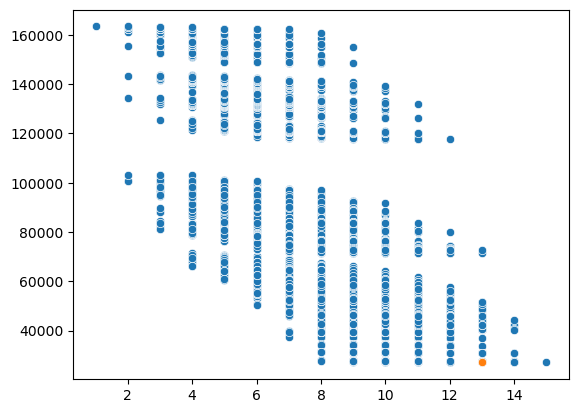

In [9]:
sns.scatterplot(x=p, y=aic)
sns.scatterplot(x=[best_p_aic], y=[best_aic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

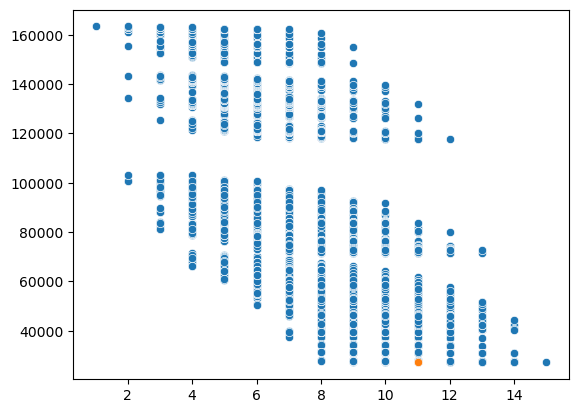

In [10]:
sns.scatterplot(x=p, y=bic)
sns.scatterplot(x=[best_p_bic], y=[best_bic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

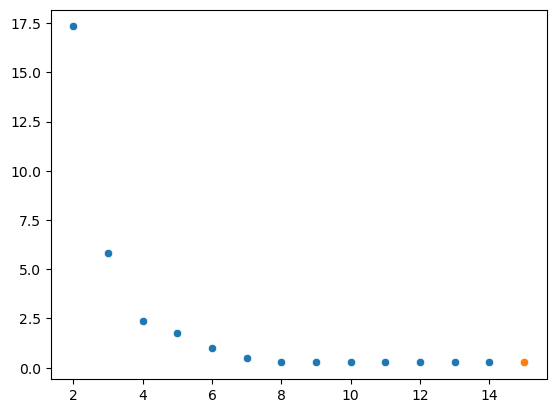

In [11]:
sns.scatterplot(x=range(1+1, len(train.columns) + 1),y=test_mse[1:])
sns.scatterplot(x=[best_p_test], y=[best_test_mse]) # note here we plot just one point, but we need to pass is as list, hence the []

## Perform Cross Validation

In [51]:
def cross_validate_models(data, model_formulas, k_folds=5, random_state=42):
    """
    Perform k-fold cross-validation on multiple models with MSE and Adjusted R²
    
    Parameters:
    -----------
    data : pd.DataFrame
        Data including target variable
    model_formulas : list
        List of model formulas to evaluate
    k_folds : int
        Number of folds for cross-validation
    random_state : int
        Random seed for reproducibility
    """
    # Initialize KFold
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    
    # Evaluate each model
    for formula in model_formulas:
        print(f"\nModel: {formula}")
        
        # Lists to store cross-validation scores
        cv_mse = []
        cv_r2_adj = []
        
        # Perform k-fold cross-validation
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(data), 1):
            # Split data into training and validation sets
            train_fold = data.iloc[train_idx]
            val_fold = data.iloc[val_idx]
            
            # Fit model on training fold
            model = ols(formula, data=train_fold).fit()
            
            # Evaluate on validation fold
            val_mse = comp_mse(model, val_fold)
            cv_mse.append(val_mse)
            
            # Calculate adjusted R² on validation fold
            val_model = ols(formula, data=val_fold).fit()
            cv_r2_adj.append(val_model.rsquared_adj)
            
            # print(f"Fold {fold_idx}:")
            # print(f"  MSE: {val_mse:.4f}")
            # print(f"  Adjusted R²: {val_model.rsquared_adj:.4f}")
        
        # Print summary statistics
        print("\nSummary:")
        print(f"Average MSE: {np.mean(cv_mse):.4f} (±{np.std(cv_mse):.4f})")
        print(f"Average Adjusted R²: {np.mean(cv_r2_adj):.4f} (±{np.std(cv_r2_adj):.4f})")

In [ ]:
# Example usage
model_formulas = [
    'Withdraw ~ Shops_DT + ATMs_DT + Weekday_DT + Center_DT + High_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High',
    ' Withdraw ~ Shops_DT + Weekday_DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High',
    'Withdraw ~ Shops_DT + ATMs_DT + Weekday_DT + Center_DT + High_DT + Downtown_NotWeekday_Center + Shops_DWC + ATMs_DWC + Shops + ATMs + Downtown + Weekday + Center + High'
]
X_cv = pd.concat([X_new,y], axis=1)
# Run cross-validation
cross_validate_models(X_cv, model_formulas)


Model: Withdraw ~ Shops_DT + ATMs_DT + Weekday__DT + Center_DT + High_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High

Summary:
Average MSE: 0.2716 (±0.0072)
Average Adjusted R²: 0.9996 (±0.0000)

Model:  Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High

Summary:
Average MSE: 0.2715 (±0.0073)
Average Adjusted R²: 0.9996 (±0.0000)

Model: Withdraw ~ Shops_DT + ATMs_DT + Weekday__DT + Center_DT + High_DT + Downtown_NotWeekday_Center + Shops_DWC + ATMs_DWC + Shops + ATMs + Downtown + Weekday + Center + High

Summary:
Average MSE: 0.2716 (±0.0072)
Average Adjusted R²: 0.9996 (±0.0000)


In [ ]:
# AIC Best Model

model = ols(best_model_aic, data=train).fit()
print("Formula is: ", best_model_aic)
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
# model.summary()

Formula is:  Withdraw ~ Shops_DT + ATMs_DT + Weekday__DT + Center_DT + High_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High
Test MSE:  0.26701927655328084
Train MSE:  0.2720816468307228


In [53]:
# BIC Best Model

model = ols(best_model_bic, data=train).fit()
print("Formula is: ", best_model_bic)
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train))  

Formula is:  Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High
Test MSE:  0.26695828238070685
Train MSE:  0.27214905965208785


In [ ]:
# Test MSE Best Model
best_model_test_mse = "Withdraw ~ Shops_DT + Weekday_DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High"
model = ols(best_model_test_mse, data=train).fit()
print("Formula is: ", best_model_test_mse)
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train))  

Formula is:  Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High
Test MSE:  0.26695828238070685
Train MSE:  0.27214905965208785


In [15]:
robust_model = model.get_robustcov_results(cov_type='HC0')
robust_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.147e+06
Date:                Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:15:54   Log-Likelihood:                -13521.
No. Observations:               17600   AIC:                         2.706e+04
Df Residuals:                   17589   BIC:                         2.715e+04
Df Model:                          10                                         
Covariance Type:                  HC0                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      18.8757      0.162    116.875      0.000      18.559      19.192
Shops_DT        0.0920      0.002     56.610      0.000       0.089       0.095
Weekday__DT     0.2337      0.021     10.949      0.000       0.192       0.276
Center_DT      -0.6000      0.045    -13.425      0.000      -0.688      -0.512
Shops_DWC       0.0200   3.07e-05    650.943      0.000       0.020       0.020
Shops           0.0180      0.002     11.146      0.000       0.015       0.021
ATMs           -0.9978      0.002   -471.180      0.000      -1.002      -0.994
Downtown      -47.8666      0.276   -173.495      0.000     -48.407     -47.326
Weekday        -2.2276      0.019   -119.630      0.000      -2.264      -2.191
Center          3.6129      0.041     87.511      0.000       3.532       3.694
High            0.9997      0.009    116.579      0.000       0.983       1.017
==============================================================================
Omnibus:                       55.056   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.973
Skew:                           0.107   Prob(JB):                     1.56e-13
Kurtosis:                       3.185   Cond. No.                     8.61e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 8.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
print(model.params)
print(robust_model.params)

Intercept      18.875729
Shops_DT        0.092045
Weekday__DT     0.233686
Center_DT      -0.599965
Shops_DWC       0.019957
Shops           0.017951
ATMs           -0.997796
Downtown      -47.866560
Weekday        -2.227631
Center          3.612861
High            0.999701
dtype: float64
[ 1.88757293e+01  9.20454513e-02  2.33685848e-01 -5.99964872e-01
  1.99570894e-02  1.79511522e-02 -9.97795654e-01 -4.78665600e+01
 -2.22763102e+00  3.61286114e+00  9.99701427e-01]


In [59]:
"""
Prediction test
"""
formula = best_model_bic
formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Downtown_NotWeekday_Center + Shops + ATMs + Downtown + Weekday + Center + High"
model = ols(formula, data=train).fit()
model.params

Intercept                     18.875764
Shops_DT                       0.092566
Weekday__DT                    0.233394
Center_DT                     -0.600061
Downtown_NotWeekday_Center    19.956276
Shops                          0.017952
ATMs                          -0.997906
Downtown                     -48.386954
Weekday                       -2.227622
Center                         3.612848
High                           1.000409
dtype: float64

In [60]:
uptown = train[train.Downtown == 0].copy()
uptown_target = uptown.Withdraw.copy()
uptown.drop(['Withdraw'], axis=1, inplace=True)

upper_downtown = train[(train.Downtown == 1) & (train.Weekday == 0) & (train.Center == 1)].copy()
upper_downtown_target = upper_downtown.Withdraw.copy()
upper_downtown.drop(['Withdraw'], axis=1, inplace=True)

middle_downtown = train[(train.Downtown == 1) & ((train.Weekday) == 1 | (train.Center == 0))].copy()
middle_downtown_target = middle_downtown.Withdraw.copy()
middle_downtown.drop(['Withdraw'], axis=1, inplace=True)

In [61]:
print(f'''
        For the uptown group, we predicted {model.predict(uptown.iloc[0]).values[0]}, 
        and the actual value was {uptown_target.iloc[0]}.

        For the upper_downtown group, we predicted {model.predict(upper_downtown.iloc[0]).values[0]}, 
        and the actual value was {upper_downtown_target.iloc[0]}.

        For the middle_downtown group, we predicted {model.predict(middle_downtown.iloc[0]).values[0]}, 
        and the actual value was {middle_downtown_target.iloc[0]}.
        '''
)



        For the uptown group, we predicted 15.413714935208109, 
        and the actual value was 14.96589142.

        For the upper_downtown group, we predicted 94.11324606690746, 
        and the actual value was 94.24257386.

        For the middle_downtown group, we predicted 76.03736286856812, 
        and the actual value was 76.28484248.
        
